In [2]:
#!/usr/bin/env python3

################################
# Scientific imports
################################
import matplotlib.pyplot as plt
import numpy as np

from astroquery.mast import Observations
from astroquery.mast import Catalogs

from astropy.table import Table
from astropy.table import QTable
from astropy.io import fits
from astropy import units as u
from astropy.timeseries import BoxLeastSquares
from astropy.timeseries import TimeSeries
from astropy.stats import sigma_clipped_stats
from astropy.timeseries import aggregate_downsample

################################
# General imports
################################
import csv, math, io, os, os.path, sys, random, time, json, gc
from datetime import datetime
import pandas as pd
import seaborn as sb
from collections import Counter

################################
# Suppress Warnings
################################
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

################################
# Initialisers
################################
plt.rcParams["figure.figsize"] = (10,6)
sb.set()

# Load the Data files
fitsarr = np.load("fitslist.npy")
global C
C = 0

In [3]:
################################
# Functions
################################

def LoadList():
    
    planet_list ="tsop301_planet_data.txt"
    star_list   ="tsop301_star_data.txt"
    eb_list     ="tsop301_eb_data.txt"
    beb_list    ="tsop301_backeb_data.txt"
    
    starlist = LoadListGeneral(star_list)
    planetlist = LoadListGeneral(planet_list)
    eblist = LoadListGeneral(eb_list)
    beblist = LoadListGeneral(beb_list)
    
    alllists = {"s": starlist, "p": planetlist, "eb": eblist, "beb": beblist}
    
    return alllists

def LoadListGeneral(f):
    
    lst=[]
    try:
        # Assuming everything CAN go well, do this
        with open('./SIM_DATA/unpacked/{}'.format(f)) as df:
            csvdf = csv.reader(df)
            for lineholder in csvdf:
                line = lineholder[0]                # 'lineholder' is a list, 1 element long, containing only a single string
                if line[0]!="#":                    # Ignore commented lines (lines w/ FIRST STRING ELEMENT is a # character)
                    lst.append(line.split()[0])     # Add line to list
                # endif
            # endfor
        # endwith
    except FileNotFoundError:
        print("FNF")
        return
    # end try
    
    return lst


# Python3 implementation to find elements
# that appeared only once
# Function to find the elements that
# appeared only once in the array
def OccurredOnce(in_arr, out_arr, count=1):
    
    n = len(in_arr)
    #counting frequency of every element using Counter
    mp=Counter(in_arr)
    # Traverse the map and print all
    # the elements with occurrence 1
    for it in mp:
        if mp[it] == count:
            out_arr.append(int(it))
            #print(it, end = " ")
    return


def MakeTimeSeries(L, f, binSize=0.2, timedBinSize=0.001):
    
    global C
    C = C+1
    print("Processing File {} of {}...".format(C,L))
    
    ts = TimeSeries.read(fitsarr[int(f)], format='tess.fits')
    periodogram = BoxLeastSquares.from_timeseries(ts, 'sap_flux')
    results = periodogram.autopower(binSize * u.day)  
    best = np.argmax(results.power)  
    period = results.period[best]
    transit_time = results.transit_time[best]
    ts_folded = ts.fold(period=period, epoch_time=transit_time)
    mean, median, stddev = sigma_clipped_stats(ts_folded['sap_flux'])
    ts_folded['sap_flux_norm'] = ts_folded['sap_flux'] / median
    ts_binned = aggregate_downsample(ts_folded, time_bin_size=timedBinSize * u.day)
    
    return(ts_binned['sap_flux_norm'].value)

def GetTICListOfOnlyZeroOrOneExoplanets(fname):
    
    master_list = LoadList()
    starList, planetList, ebList, bebList = master_list['s'], master_list['p'], master_list['eb'], master_list['beb']
    starList   = [int(x) for x in starList]
    planetList = [int(x) for x in planetList]
    ebList     = [int(x) for x in ebList]
    bebList    = [int(x) for x in bebList]
    
    TICList=list(np.load("TICList.npy"))
    print("TICList is {} entries long".format(len(TICList)))
    
    #####################
    
    one_planet_lcs = []
    lst_a = one_planet_lcs
    
    OccurredOnce(planetList, one_planet_lcs)
    
    #####################
    
    fLen = len(fluxarr)
#    print("The file '{}' contains a list of {} LCs!".format(fname,fLen))
    
    zero_or_one_exoplanets = list(set(starList + one_planet_lcs))
    zero_or_one_exoplanets.sort()
    
    flist = [TICList.index(zero_or_one_exoplanets[x]) for x in range(len(zero_or_one_exoplanets))]
    print("FList has {} entries".format(len(flist)))
    
    # 'flist' now contains a list of file indices of the FITS files that contain Zero or One exoplanet.
    
    np.save(fname,flist)

In [4]:
################################
# main
################################

def main():
    
    # Making sure we have only one cmd line parameter and it is the fluxlist that we want
    try:
        #print(sys.argv)
        fname = sys.argv[1]
        fluxarr = np.load(fname)
    except FileNotFoundError:
        print("This File Does Not Exist")
        #break
    except IndexError:
        print("Please add exactly one numpy file to the command line!")
        #break
    except:
        print("General Error")
        #break
    print("Done!")
    
    #####################
    
    npFileName = "ZeroOrOneExoplanetTICids.npy"
    try:
        ZeroOrOneTICList = np.load(npFileName)
    except FileNotFoundError:
        print("This File Does Not Exist; Making it now!")
        GetTICListOfOnlyZeroOrOneExoplanets(npFileName)
    print("File '{}' loaded".format(npFileName))
    
    #####################

    #foldedFluxes = np.empty(ZeroOrOneTICList)
    #for i in range(len(foldedFluxes))
    
    
    C = 0
    L = len(ZeroOrOneTICList)
    
    
    # TESTING PURPOSES
    ZeroOrOneTICList = ZeroOrOneTICList[:3]
    
    
    foldedFluxes = np.array([MakeTimeSeries(L,x) for x in ZeroOrOneTICList])
    #print("Length of foldedFlux[0] is {}".format(len(foldedFluxes[0])))
    #print("fFlux[0]:\n{}".format(foldedFluxes[0]))
    #np.save("ZeroOrOneFoldedFluxes.npy",foldedFluxes)
    #print("YAY")
    return foldedFluxes

In [5]:
foldedFluxes = np.load("ZeroOrOneFoldedFluxes.npy") #, allow_pickle=True)
#np.save("ZeroOrOneFoldedFluxesPREFOLD.npy",foldedFluxes)

In [5]:
foldedFluxes

array([[0.99261886, 0.99601656, 0.9981048 , ..., 1.0008711 , 1.0002829 ,
        0.9980786 ],
       [0.99275607, 0.9947057 , 0.99220985, ..., 0.99424696, 0.9969075 ,
        0.99439085],
       [0.99182147, 0.99367297, 0.9923835 , ..., 0.9948798 , 0.9958051 ,
        0.99556094],
       ...,
       [0.9890697 , 0.9769344 , 0.97957677, ..., 1.0160047 , 0.97483426,
        1.0031875 ],
       [1.0644528 , 1.065649  , 1.0678988 , ..., 0.9803245 , 0.9800736 ,
        0.9799673 ],
       [1.0329845 , 0.98421675, 0.82539517, ..., 0.97136945, 0.9921893 ,
        1.0005776 ]], dtype=float32)

In [6]:
nanlist=[]
for i in range(len(foldedFluxes)):
    if np.isnan(np.sum(foldedFluxes[i])):
        #print(np.argwhere(np.isnan(foldedFluxes[i])))
        print("NaN detected at entry {} and datapoint {}".format(i,np.argwhere(np.isnan(foldedFluxes[i]))))
        nanlist.append(i)
    #array_sum = np.sum(foldedFluxes[9152])
    #print(np.isnan(array_sum))

NaN detected at entry 308 and datapoint [[3908]]
NaN detected at entry 972 and datapoint [[3908]]
NaN detected at entry 2444 and datapoint [[3908]]
NaN detected at entry 7250 and datapoint [[3908]]


In [7]:
nanlist

[308, 972, 2444, 7250]

In [8]:
foldedFluxes[nanlist[0]][3900:3910]

array([1.0067822, 1.0001757, 1.005702 , 1.0013194, 1.0071235, 1.0034333,
       1.0043252, 1.0036362,       nan, 1.0021263], dtype=float32)

In [9]:
nanNum = 3908
for i in nanlist:
    dif = np.nanmean(foldedFluxes[i][nanNum-1:nanNum+2])
    foldedFluxes[i][nanNum] = dif
    
    print(dif)

1.0028813
1.0007634
1.0002681
1.0017579


In [10]:
TEST = np.load("ZeroOrOneFoldedFluxes_TEST.npy",allow_pickle=True)

FileNotFoundError: [Errno 2] No such file or directory: 'ZeroOrOneFoldedFluxes_TEST.npy'

In [25]:
colList = ['time','timecorr','cadenceno','sap_flux','sap_flux_err','sap_bkg','sap_bkg_err','pdcsap_flux','pdcsap_flux_err','quality','psf_centr1','psf_centr1_err','psf_centr2','psf_centr2_err','mom_centr1','mom_centr1_err','mom_centr2','mom_centr2_err','pos_corr1','pos_corr2','sap_flux_norm']
TEST

NameError: name 'TEST' is not defined

In [26]:
df = pd.DataFrame(arrO, columns=colList, index=['time'])

NameError: name 'arrO' is not defined

In [24]:
a = np.array([1, 4, 5], dtype=np.int32)
b = [2.0, 5.0, 8.5]
c = ['x', 'y', 'z']
d = [10, 20, 30] * u.m / u.s

In [27]:
t = QTable([a, b, c, d],
           names=('a', 'b', 'c', 'd'),
           meta={'name': 'first table'})

In [28]:
t

a,b,c,d
,,,m / s
int32,float64,str1,float64
1,2.0,x,10.0
4,5.0,y,20.0
5,8.5,z,30.0


In [63]:
df = pd.DataFrame({'name': ['Raphael', 'Donatello'],
                   'mask': ['red', 'purple'],
                   'weapon': ['sai', 'bo staff']})

In [70]:
df.to_csv(path_or_buf="TST_CSV.csv", index=False, index_label='name')

In [71]:
QQQ = pd.read_csv("TST_CSV.csv")

In [72]:
QQQ

,name,mask,weapon
0,Raphael,red,sai
1,Donatello,purple,bo staff


In [38]:
t2 = Table.from_pandas(QQQ)

In [39]:
t2

name,mask,weapon
str9,str6,str8
Raphael,red,sai
Donatello,purple,bo staff


In [13]:
def MakeFolded(L, f, binSize=0.2, timedBinSize=0.03):
    
    global C
    C = C+1
    print("Processing File {} of {}...".format(C,L))
    
    ts = TimeSeries.read(fitsarr[int(f)], format='tess.fits')
    periodogram = BoxLeastSquares.from_timeseries(ts, 'sap_flux')
    results = periodogram.autopower(binSize * u.day)  
    best = np.argmax(results.power)  
    period = results.period[best]
    transit_time = results.transit_time[best]
    ts_folded = ts.fold(period=period, epoch_time=transit_time)
    # Delete unnecessary vars
    del ts, periodogram, period, results, best, transit_time
    
    #return(ts_folded['sap_flux_norm'].value)
    return(ts_folded)

def MakeTimeSeries(L, f, binSize=0.2, timedBinSize=0.03):
    
    ts_folded = MakeFolded(L, f, binSize=0.2, timedBinSize=0.03)
    
    mean, median, stddev = sigma_clipped_stats(ts_folded['sap_flux'])
    ts_folded['sap_flux_norm'] = ts_folded['sap_flux'] / median
    ts_binned = aggregate_downsample(ts_folded, time_bin_size=timedBinSize * u.day)
    
    # Delete unnecessary vars
    del mean, median, stddev, ts_folded
    
    #return(ts_folded['sap_flux_norm'].value)
    return(ts_binned)

In [12]:
Z = np.load("ZeroOrOneExoplanetTICids.npy")

In [14]:
chunkSize = 10
Zchunks = [Z[x:x+chunkSize] for x in range(0, len(Z), chunkSize)]
#Zchunks

In [15]:
L = [MakeFolded(len(Z),X) for X in Zchunks[0]]
print("### Converting to Dataframe! ###")

Processing File 1 of 9154...
Processing File 2 of 9154...
Processing File 3 of 9154...
Processing File 4 of 9154...
Processing File 5 of 9154...
Processing File 6 of 9154...
Processing File 7 of 9154...
Processing File 8 of 9154...
Processing File 9 of 9154...
Processing File 10 of 9154...
### Converting to Dataframe! ###


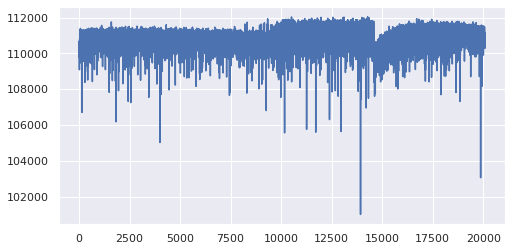

In [16]:
plt.plot(L[0]['sap_flux'])

In [17]:
L[0]

time,timecorr,cadenceno,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,d,,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
object,float32,int32,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
0.04517404901672206,5.2809059e-03,1091,1.1001307e+05,3.2275578e+01,4.0405876e+03,4.8348794e+00,0.0000000e+00,0.0000000e+00,1000,nan,nan,nan,nan,1029.88398,2.1809449e-04,1008.83361,2.2562544e-04,nan,nan
0.046562916485171524,5.2808844e-03,1092,1.1038964e+05,3.2322845e+01,4.0298765e+03,4.8227181e+00,1.1679643e+05,3.6730911e+01,10000000000,nan,nan,nan,nan,1029.91966,2.1312594e-04,1008.83197,2.2573731e-04,8.4771983e-02,-5.6619313e-02
0.047951783953620986,5.2808630e-03,1093,1.1062109e+05,3.2359745e+01,4.0317603e+03,4.8324327e+00,1.1720580e+05,3.6772842e+01,0,nan,nan,nan,nan,1029.90206,2.1424357e-04,1008.80879,2.2678117e-04,6.2888488e-02,-8.5854538e-02
0.04934065142207045,5.2808416e-03,1094,1.0993336e+05,3.2270397e+01,4.0742517e+03,4.8466444e+00,1.1668638e+05,3.6671310e+01,0,nan,nan,nan,nan,1029.89821,2.1688615e-04,1008.84236,2.2707430e-04,6.1745681e-02,-4.4943392e-02
0.05072951889051991,5.2808202e-03,1095,1.1022224e+05,3.2299232e+01,4.0130669e+03,4.8152390e+00,1.1694662e+05,3.6704082e+01,0,nan,nan,nan,nan,1029.94696,2.1266939e-04,1008.82306,2.2593014e-04,1.1984909e-01,-6.5892421e-02
0.05211838635896937,5.2807988e-03,1096,1.1022213e+05,3.2303185e+01,4.0410913e+03,4.8295302e+00,1.1681645e+05,3.6708569e+01,10000000000,nan,nan,nan,nan,1029.90242,2.1566286e-04,1008.84036,2.2583459e-04,6.9559462e-02,-4.7780402e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-2.8709631074961983,4.3881186e-03,21424,1.1027464e+05,3.2259743e+01,3.8435598e+03,4.7210698e+00,1.1701558e+05,3.6659203e+01,0,nan,nan,nan,nan,1029.90590,2.1593980e-04,1008.92402,2.2460571e-04,6.7923486e-02,5.2096080e-02


In [18]:
#LDF = [X.to_pandas().drop(dropcols, axis=1) for X in L]
LDF = [X.to_pandas() for X in L]
print("\n### Converting Done! ###")
#del L


### Converting Done! ###


In [307]:
# 1) Make List                   foldedFluxes = [MakeTimeSeries(lenTIC,x) for x in ZeroOrOneTICList]
# 2) Turn List to DataFrame      LDF = [X.to_pandas().drop(dropcols, axis=1) for X in L]
# 3) Save DataFrame to file      LDF.to_csv(path_or_buf="TST_CSV.csv", index=False)

In [19]:
DF = pd.DataFrame(LDF[0])
DF

,timecorr,cadenceno,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
time,,,,,,,,,,,,,,,,,,,
0 days 01:05:03.037835044,0.005281,1091,110013.070312,32.275578,4040.587646,4.834879,0.000000,0.000000,8,NaN,NaN,NaN,NaN,1029.883983,0.000218,1008.833614,0.000226,NaN,NaN
0 days 01:07:03.035984318,0.005281,1092,110389.640625,32.322845,4029.876465,4.822718,116796.429688,36.730911,1024,NaN,NaN,NaN,NaN,1029.919661,0.000213,1008.831970,0.000226,0.084772,-0.056619
0 days 01:09:03.034133592,0.005281,1093,110621.085938,32.359745,4031.760254,4.832433,117205.796875,36.772842,0,NaN,NaN,NaN,NaN,1029.902061,0.000214,1008.808789,0.000227,0.062888,-0.085855
0 days 01:11:03.032282866,0.005281,1094,109933.359375,32.270397,4074.251709,4.846644,116686.375000,36.671310,0,NaN,NaN,NaN,NaN,1029.898211,0.000217,1008.842360,0.000227,0.061746,-0.044943
0 days 01:13:03.030432140,0.005281,1095,110222.242188,32.299232,4013.066895,4.815239,116946.625000,36.704082,0,NaN,NaN,NaN,NaN,1029.946960,0.000213,1008.823060,0.000226,0.119849,-0.065892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-3 days +03:09:48.774758441,0.004388,21426,110581.265625,32.296600,3833.596191,4.719143,116719.281250,36.701084,0,NaN,NaN,NaN,NaN,1029.914059,0.000211,1008.940135,0.000224,0.075947,0.070438
-3 days +03:11:48.768361371,0.004388,21427,110271.859375,32.260452,3852.258057,4.730487,116513.335938,36.660007,0,NaN,NaN,NaN,NaN,1029.871366,0.000215,1008.954695,0.000224,0.024664,0.088764
-3 days +03:13:48.761964301,0.004388,21428,110927.679688,32.349358,3836.199951,4.723638,116858.820312,36.761040,1024,NaN,NaN,NaN,NaN,1029.855148,0.000214,1008.937179,0.000224,-0.000200,0.062249


In [23]:
dropcols = ['timecorr', 'cadenceno', 'sap_bkg', 'sap_bkg_err', 'quality',
       'psf_centr1', 'psf_centr1_err', 'psf_centr2', 'psf_centr2_err',
       'mom_centr1', 'mom_centr1_err', 'mom_centr2', 'mom_centr2_err',
       'pos_corr1', 'pos_corr2']
goodCols = ['time', 'sap_flux', 'sap_flux_err', 'pdcsap_flux', 'pdcsap_flux_err', 'sap_flux_norm']

In [24]:
#LDF = [X.to_pandas().drop(dropcols, axis=1).reset_index() for X in L]

LDF[0]

,timecorr,cadenceno,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
time,,,,,,,,,,,,,,,,,,,
0 days 01:05:03.037835044,0.005281,1091,110013.070312,32.275578,4040.587646,4.834879,0.000000,0.000000,8,NaN,NaN,NaN,NaN,1029.883983,0.000218,1008.833614,0.000226,NaN,NaN
0 days 01:07:03.035984318,0.005281,1092,110389.640625,32.322845,4029.876465,4.822718,116796.429688,36.730911,1024,NaN,NaN,NaN,NaN,1029.919661,0.000213,1008.831970,0.000226,0.084772,-0.056619
0 days 01:09:03.034133592,0.005281,1093,110621.085938,32.359745,4031.760254,4.832433,117205.796875,36.772842,0,NaN,NaN,NaN,NaN,1029.902061,0.000214,1008.808789,0.000227,0.062888,-0.085855
0 days 01:11:03.032282866,0.005281,1094,109933.359375,32.270397,4074.251709,4.846644,116686.375000,36.671310,0,NaN,NaN,NaN,NaN,1029.898211,0.000217,1008.842360,0.000227,0.061746,-0.044943
0 days 01:13:03.030432140,0.005281,1095,110222.242188,32.299232,4013.066895,4.815239,116946.625000,36.704082,0,NaN,NaN,NaN,NaN,1029.946960,0.000213,1008.823060,0.000226,0.119849,-0.065892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-3 days +03:09:48.774758441,0.004388,21426,110581.265625,32.296600,3833.596191,4.719143,116719.281250,36.701084,0,NaN,NaN,NaN,NaN,1029.914059,0.000211,1008.940135,0.000224,0.075947,0.070438
-3 days +03:11:48.768361371,0.004388,21427,110271.859375,32.260452,3852.258057,4.730487,116513.335938,36.660007,0,NaN,NaN,NaN,NaN,1029.871366,0.000215,1008.954695,0.000224,0.024664,0.088764
-3 days +03:13:48.761964301,0.004388,21428,110927.679688,32.349358,3836.199951,4.723638,116858.820312,36.761040,1024,NaN,NaN,NaN,NaN,1029.855148,0.000214,1008.937179,0.000224,-0.000200,0.062249


In [498]:
np.save("TST_CSV.npy",LDF)

In [500]:
#QWERTY = pd.read_csQWERTY = pd.read_csv('TESTIN.csv')v('TESTIN.csv')
ASDFGH = [np.vstack((goodCols, X)) for X in np.load("TST_CSV.npy", allow_pickle=True)]

In [502]:
#ASDFGH = [np.vstack((goodCols, X)) for X in ASDFGH]
ASDFGH[0]

array([['time', 'sap_flux', 'sap_flux_err', 'pdcsap_flux',
        'pdcsap_flux_err', 'sap_flux_norm'],
       [Timedelta('0 days 01:05:03.037835044'), 110013.0703125,
        32.275577545166016, 0.0, 0.0, 0.9926188588142395],
       [Timedelta('0 days 01:07:03.035984318'), 110389.640625,
        32.322845458984375, 116796.4296875, 36.73091125488281,
        0.9960165619850159],
       ...,
       [Timedelta('-3 days +03:13:48.761964301'), 110927.6796875,
        32.34935760498047, 116858.8203125, 36.76103973388672,
        1.0008710622787476],
       [Timedelta('-3 days +03:15:48.755567231'), 110862.484375,
        32.3392448425293, 116742.9453125, 36.74954605102539,
        1.000282883644104],
       [Timedelta('-3 days +03:17:48.749170160'), 110618.1796875,
        32.3165283203125, 0.0, 0.0, 0.9980785846710205]], dtype=object)

In [415]:
Q = np.vstack((goodCols, ASDFGH[0]))
Q

array([['sap_flux', 'sap_flux_err', 'pdcsap_flux', 'pdcsap_flux_err',
        'sap_flux_norm'],
       ['110013.07', '32.275578', '0.0', '0.0', '0.99261886'],
       ['110389.64', '32.322845', '116796.43', '36.73091', '0.99601656'],
       ...,
       ['110927.68', '32.349358', '116858.82', '36.76104', '1.0008711'],
       ['110862.484', '32.339245', '116742.945', '36.749546',
        '1.0002829'],
       ['110618.18', '32.31653', '0.0', '0.0', '0.9980786']], dtype='<U32')

In [214]:
ts_binned = aggregate_downsample(L[0], time_bin_size=0.03 * u.day)

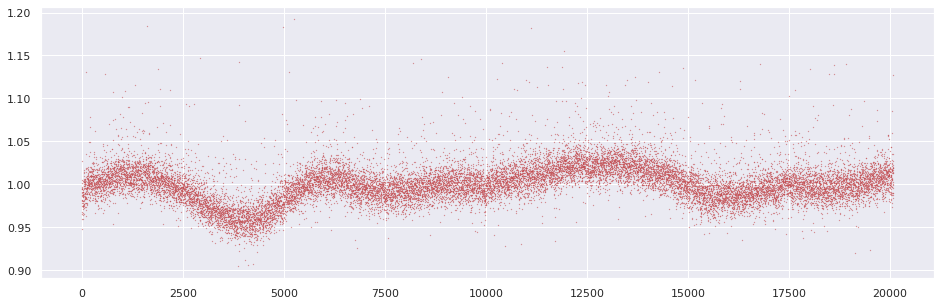

In [171]:
plt.plot(foldedFluxes[3908], 'r.', markersize=0.5)

In [127]:
maxnan = 0
for i in foldedFluxes:
    k = len(np.argwhere(np.isnan(i)))
    if k > maxnan:
        maxnan = k
print(k)

0


In [5]:
GNB=[[8,1738],
    [2,541]]

KNN=[[1745,1],
    [543,0]]

RDT=[[1723,23],
    [509,34]]

SVM=[[82,1664],
    [14,529]]

YES = [[0,1746],
       [0,543]]

NOO = [[1746,0],
       [543,0]] 

SVM:
82, 1664
14, 529

GNB:
8, 1738
2, 541

KNN:
1745, 1
543, 0

RDT:
1723, 23
509, 34

In [6]:
def Metrics(a):
    # Assuimng 'a' is a 2x2 matrix
    TN, FP, FN, TP = a[0][0], a[0][1], a[1][0], a[1][1]
    
    Acc = (TP+TN)/(TP+TN+FP+FN)
    Pre = (TP)/(TP+FP) if (TP+FP) != 0 else 0
    Rec = (TP)/(TP+FN) if (TP+FN) != 0 else 0
    
    return ({'Accuracy': Acc, 'Precision': Pre, 'Recall': Rec})

GNB_metrics = Metrics(GNB)
KNN_metrics = Metrics(KNN)
RDT_metrics = Metrics(RDT)
SVM_metrics = Metrics(SVM)
YES_metrics = Metrics(YES)
NOO_metrics = Metrics(NOO)
MNK_metrics = {'Accuracy': 0.5111402359108781, 'Precision': 0.2528837622005324, 'Recall': 0.5071174377224199}

In [7]:
NOO_metrics

{'Accuracy': 0.762778505897772, 'Precision': 0, 'Recall': 0.0}

In [8]:
accs = [GNB_metrics['Accuracy'], KNN_metrics['Accuracy'], RDT_metrics['Accuracy'], SVM_metrics['Accuracy'], YES_metrics['Accuracy'], NOO_metrics['Accuracy']]
pres = [GNB_metrics['Precision'], KNN_metrics['Precision'], RDT_metrics['Precision'], SVM_metrics['Precision'], YES_metrics['Precision'], NOO_metrics['Precision']]
recs = [GNB_metrics['Recall'], KNN_metrics['Recall'], RDT_metrics['Recall'], SVM_metrics['Recall'], YES_metrics['Recall'], NOO_metrics['Recall']]

In [9]:
accs_pct = ['{:,.1%}'.format(x) for x in accs]
pres_pct = ['{:,.1%}'.format(x) for x in pres]
recs_pct = ['{:,.1%}'.format(x) for x in recs]

[Text(0, 0.0, '0%'),
 Text(0, 0.1, '10%'),
 Text(0, 0.2, '20%'),
 Text(0, 0.30000000000000004, '30%'),
 Text(0, 0.4, '40%'),
 Text(0, 0.5, '50%'),
 Text(0, 0.6000000000000001, '60%'),
 Text(0, 0.7000000000000001, '70%'),
 Text(0, 0.8, '80%'),
 Text(0, 0.9, '90%')]

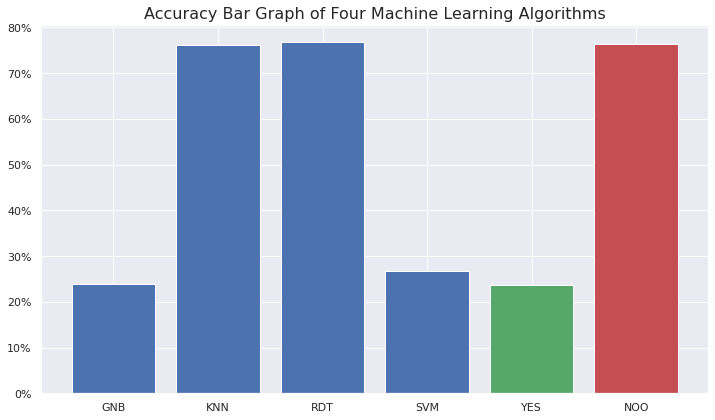

In [10]:
x = np.arange(6)
plt.bar(x,accs,color=['b', 'b', 'b', 'b', 'g', 'r'])
plt.xticks(x,["GNB","KNN","RDT","SVM","YES","NOO"])
plt.title("Accuracy Bar Graph of Four Machine Learning Algorithms", fontsize=16)
plt.tight_layout()
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
#plt.savefig('img/accuracy-norm-bar.png')

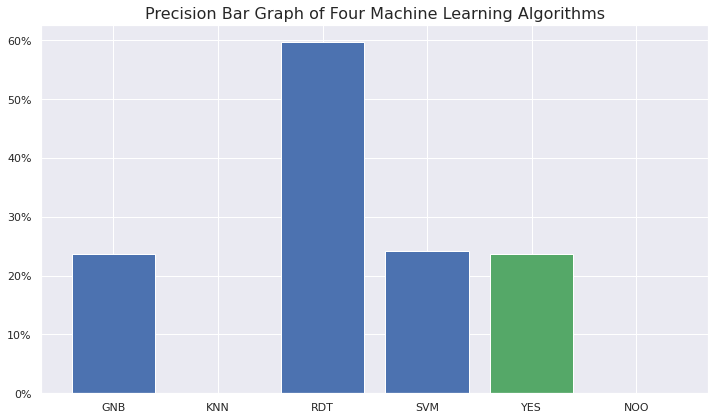

In [11]:
x = np.arange(6)
plt.bar(x,pres,color=['b', 'b', 'b', 'b', 'g', 'r'])
plt.xticks(x,["GNB","KNN","RDT","SVM","YES","NOO"])
plt.title("Precision Bar Graph of Four Machine Learning Algorithms", fontsize=16)
plt.tight_layout()
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.savefig('img/precision-norm-bar.png')

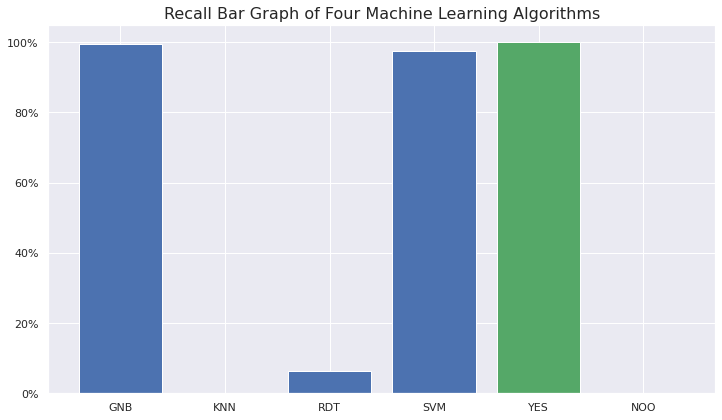

In [12]:
x = np.arange(6)
plt.bar(x,recs,color=['b', 'b', 'b', 'b', 'g', 'r'])
plt.xticks(x,["GNB","KNN","RDT","SVM","YES","NOO"])
plt.title("Recall Bar Graph of Four Machine Learning Algorithms", fontsize=16)
plt.tight_layout()
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.savefig('img/recall-norm-bar.png')

In [13]:
mainList = [[0]*3]*len(accs)

for i in range(len(accs)):
    mainList[i] = [accs[i], pres[i], recs[i]]

mainList

[[0.2398427260812582, 0.23738481790258886, 0.996316758747698],
 [0.762341633901267, 0.0, 0.0],
 [0.7675840978593272, 0.5964912280701754, 0.06261510128913444],
 [0.2669287898645697, 0.24122207022343822, 0.9742173112338858],
 [0.23722149410222804, 0.23722149410222804, 1.0],
 [0.762778505897772, 0, 0.0]]

In [14]:
mainList += [list(MNK_metrics.values())]

In [15]:
mainList

[[0.2398427260812582, 0.23738481790258886, 0.996316758747698],
 [0.762341633901267, 0.0, 0.0],
 [0.7675840978593272, 0.5964912280701754, 0.06261510128913444],
 [0.2669287898645697, 0.24122207022343822, 0.9742173112338858],
 [0.23722149410222804, 0.23722149410222804, 1.0],
 [0.762778505897772, 0, 0.0],
 [0.5111402359108781, 0.2528837622005324, 0.5071174377224199]]

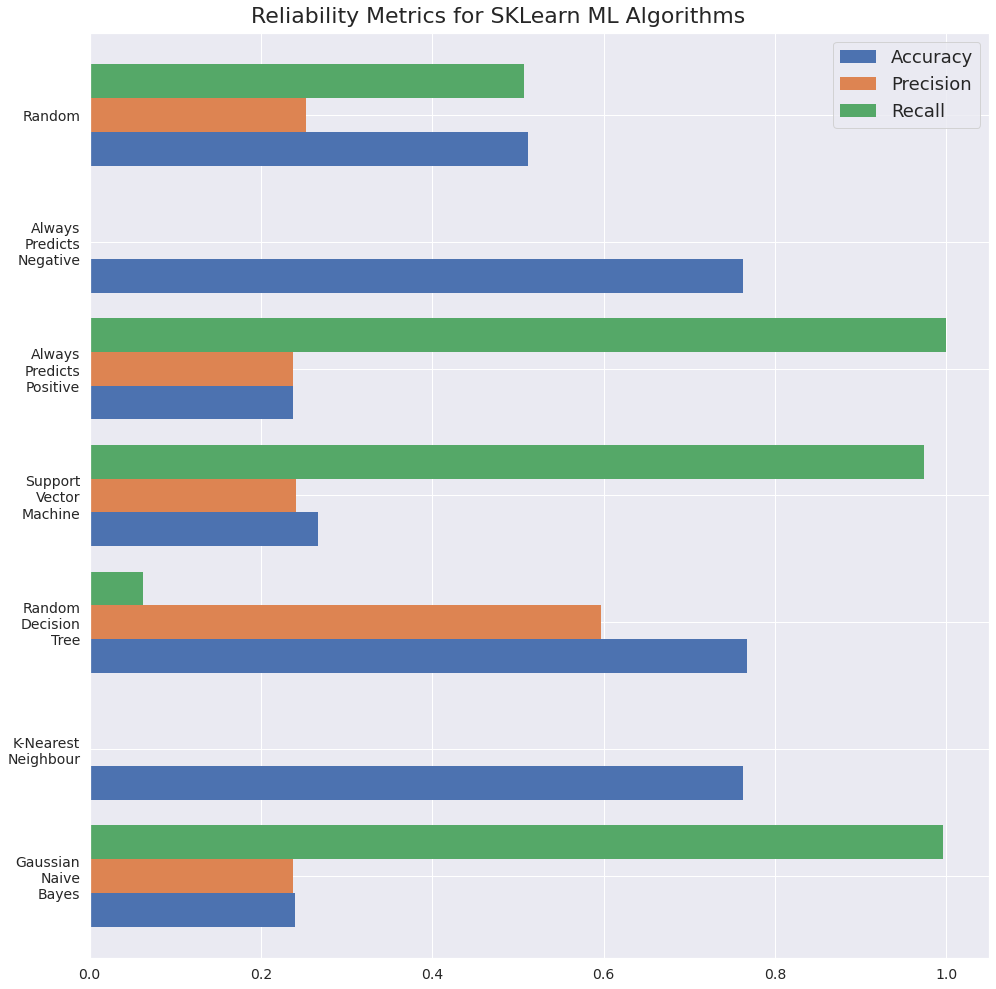

In [19]:
plt.rcParams["figure.figsize"] = (14,14)

columnList = ['Accuracy', 'Precision', 'Recall']
algoList = ['Gaussian\nNaive\nBayes', 'K-Nearest\nNeighbour', 'Random\nDecision\nTree', 'Support\nVector\nMachine', 'Always\nPredicts\nPositive', 'Always\nPredicts\nNegative', 'Random']
df = pd.DataFrame(mainList, columns=columnList, index=algoList)

fig = df.plot.barh(rot=0, ylim=[0,1], fontsize=14, width = 0.8, linewidth=0)
plt.gcf().suptitle("Reliability Metrics for SKLearn ML Algorithms",fontsize=22)
fig.legend(loc=0, prop={'size': 18})
plt.tight_layout()
fig.figure.savefig("./img/SKLearn_Metrics.png")

plt.rcParams["figure.figsize"] = (10,6)